# Sequential Decision Making in WhyNot

WhyNot presents a unified interface with the [OpenAI gym](https://github.com/openai/gym), 
which makes it easy to run sequential decision making experiments on simulators in WhyNot.

In this notebook, we showcase the API through a comparison of two simple policies. For a full example with
reinforcement learning, see our policy gradient experiments on the 
[HIV simulator](https://github.com/zykls/whynot/blob/master/examples/reinforcement_learning/hiv_simulator.ipynb).

In [2]:
%load_ext autoreload
%autoreload 2
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

import whynot as wn
import whynot.gym as gym

from scripts import utils

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up the environment

WhyNot provides exactly the same interface as the OpenAI gym.

In [3]:
for env in gym.envs.registry.all():
    print(env.id)

HIV-v0
world3-v0
opioid-v0


In [4]:
env = gym.make('world3-v0')
env.seed(1);

## Construct baseline policies

We compare two trivial baselines. One policy that takes actions randomly and other that always opts
to perform no treatment.

In [5]:
class NoTreatmentPolicy(utils.Policy):
    def __init__(self):
        super(NoTreatmentPolicy, self).__init__(env)
    
    def sample_action(self, obs):
        return 4

class RandomPolicy(utils.Policy):
    def __init__(self):
        super(RandomPolicy, self).__init__(env)
    
    def sample_action(self, obs):
        return np.random.randint(env.action_space.n)
    
policies = {
    "no_treatment": NoTreatmentPolicy(),
    "random": RandomPolicy(),
}

## Sampling trajectories

We sample trajectories according to a policy by sampling an action `ac`, taking the action via `env.step(ac)`,
observing the next state and reward, and then repeating.

In [6]:
def sample_trajectory(env, policy, max_episode_length):
    """Sample a single trajectory, acting according to the specified policy."""
    # initialize env for the beginning of a new rollout
    ob = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        # Use the most recent observation to decide what to do
        obs.append(ob)
        ac = policy.sample_action(ob)
        acs.append(ac)

        # Take that action and record results
        ob, rew, done, _ = env.step(ac)

        # Record result of taking that action
        steps += 1
        next_obs.append(ob)
        rewards.append(rew)

        # End the rollout if the rollout ended
        # Note that the rollout can end due to done, or due to max_episode_length
        if done or steps > max_episode_length:
            rollout_done = 1
        else:
            rollout_done = 0
        terminals.append(rollout_done)
        if rollout_done:
            break

    return {"observation" : np.array(obs, dtype=np.float32),
            "reward" : np.array(rewards, dtype=np.float32),
            "action" : np.array(acs, dtype=np.float32),
            "next_observation": np.array(next_obs, dtype=np.float32),
            "terminal": np.array(terminals, dtype=np.float32)}

## Visualize sampled trajectories for each policy

In [10]:
def plot_sample_trajectory(policies):
    """Plot sample trajectories from policies."""
    obs_dim_names = wn.world3.State.variable_names()

    fig, axes = plt.subplots(5, 3, sharex=True, figsize=[12, 12])
    axes = axes.flatten()
    
    for name, policy in policies.items():
        trajectory = sample_trajectory(env, policy, 400)
        obs = trajectory["observation"]
        # Plot state evolution
        for i in range(len(obs_dim_names)):
            y = obs[:, i]
            axes[i].plot(y, label=name)
            axes[i].set_ylabel(obs_dim_names[i])
            ymin, ymax = axes[i].get_ylim()
            axes[i].set_ylim(np.minimum(ymin, y.min()), np.maximum(ymax, y.max()))
        
        # Plot actions
        resource_usages = [0.8, 1.0, 1.2]
        pollution_generations = [0.8, 1.0, 1.2]

        action_map = dict(enumerate((product(resource_usages, pollution_generations))))
        
        action = np.array(trajectory["action"])
        epsilon_1 = np.array([action_map[a][0] for a in action])
        epsilon_2 = np.array([action_map[a][1] for a in action])
        axes[-3].plot(epsilon_1, label=name)
        axes[-3].set_ylabel("Resource Usage")
        axes[-3].set_ylim(0.5, 1.5)
        axes[-2].plot(epsilon_2, label=name)
        axes[-2].set_ylabel("Pollution Generation")
        axes[-2].set_ylim(0.5, 1.5)
        
        # Plot reward
        reward = trajectory["reward"]
        axes[-1].plot(reward, label=name)
        axes[-1].set_ylabel("reward")
        axes[-1].ticklabel_format(scilimits=(-2, 2))
        ymin, ymax = axes[-1].get_ylim()
        axes[-1].set_ylim(np.minimum(ymin, reward.min()), np.maximum(ymax, reward.max()))
    
        print(f"Total reward for {name}: {np.sum(reward):.2f}")
        
    for ax in axes:
        ax.legend()
        ax.set_xlabel("Year")
    plt.show()

Total reward for no_treatment: -1228018.88
Total reward for random: -1222791.25


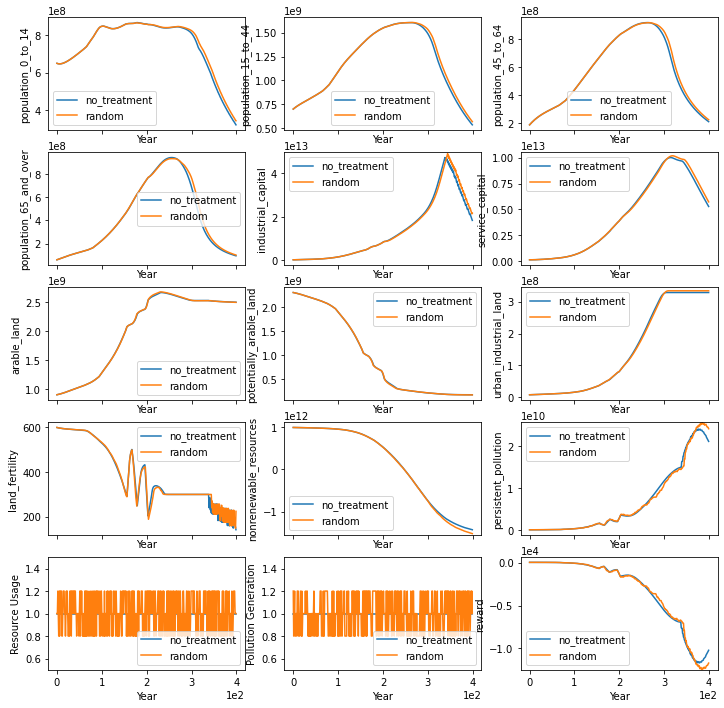

In [11]:
plot_sample_trajectory(policies)